# Adversarial attacks and robustness for quantum machine learning
Based on the PennyLane [demo](https://pennylane.ai/qml/demos/tutorial_adversarial_attacks_QML). Refer to this [paper](https://arxiv.org/abs/2404.16154).

In [1]:
import pennylane as qml
from pennylane import numpy as np
import torch # to use PennyLane TorchLayer class to perform circuit operations and optimisations with PyTorch backend
from matplotlib import pyplot as plt

### Visualisation of the dataset

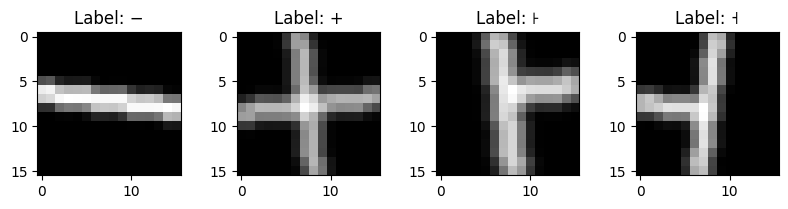

In [2]:
# we can use the dataset hosted on PennyLane
# 'plus-minus' is a low dimensional dataset and can be useful to perform scalable training
# while also serves as a baseline for evaluating QML image classification model's ability to find useful features in the input
[pm] = qml.data.load('other', name='plus-minus') 

X_train = pm.img_train  # shape (1000,16,16)
X_test = pm.img_test  # shape (200,16,16)
Y_train = pm.labels_train  # shape (1000,)
Y_test = pm.labels_test  # shape (200,)

# show one image from each class (in the train- and testsets, the images are randomly permuted)
x_vis = [
    (X_train[Y_train == 0])[0],
    (X_train[Y_train == 1])[0],
    (X_train[Y_train == 2])[0],
    (X_train[Y_train == 3])[0],
]
y_vis = [0, 1, 2, 3]


# later when we train the model we include the predictions as well, so let's just add the functionality here
def visualize_data(x, y, pred=None):
    n_img = len(x)
    labels_list = ["\u2212", "\u002b", "\ua714", "\u02e7"]
    fig, axes = plt.subplots(1, 4, figsize=(8, 2))
    for i in range(n_img):
        axes[i].imshow(x[i], cmap="gray")
        if pred is None:
            axes[i].set_title("Label: {}".format(labels_list[y[i]]))
        else:
            axes[i].set_title("Label: {}, Pred: {}".format(labels_list[y[i]], labels_list[pred[i]]))
    plt.tight_layout(w_pad=2)
    # plt.show()


visualize_data(x_vis, y_vis)

In [3]:
print('X')
print(f'Shape : {X_train.shape}')
print(f'dType : {X_train.dtype}')
print(f'pyType: {type(X_train)}')

print('Y')
print(f'Shape : {Y_train.shape}')
print(f'dType : {Y_train.dtype}')
print(f'pyType: {type(Y_train)}')

X
Shape : (1000, 16, 16)
dType : float32
pyType: <class 'pennylane.numpy.tensor.tensor'>
Y
Shape : (1000,)
dType : int64
pyType: <class 'numpy.ndarray'>


2025-04-30 00:05:22.051917: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745935522.067825   63984 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745935522.072722   63984 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745935522.085261   63984 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745935522.085276   63984 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745935522.085278   63984 computation_placer.cc:177] computation placer alr

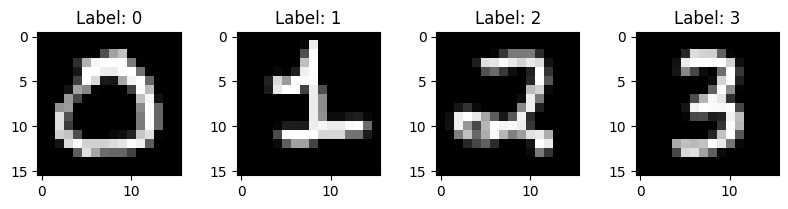

In [4]:
from utils.tools import get_dataset, visualise_data

digits = [0,1,2,3]
n_px = 16

(x_train, y_train), (x_test, y_test) = get_dataset(digits=digits, n_px=n_px)

# show one image from each class
x_vis = [(x_train[y_train==digit])[np.random.choice(range(10))] for digit in digits] 
y_vis = range(len(digits))

visualise_data(digits, x_vis, y_vis)

In [5]:
X_train = np.reshape(x_train, (len(x_train), n_px, n_px))
X_test = np.reshape(x_test, (len(x_test), n_px, n_px))
Y_train = y_train
Y_test = y_test

print('X')
print(f'Shape : {X_train.shape}')
print(f'dType : {X_train.dtype}')
print(f'pyType: {type(X_train)}')

print('Y')
print(f'Shape : {Y_train.shape}')
print(f'dType : {Y_train.dtype}')
print(f'pyType: {type(Y_train)}')

X
Shape : (1000, 16, 16)
dType : float32
pyType: <class 'pennylane.numpy.tensor.tensor'>
Y
Shape : (1000,)
dType : uint8
pyType: <class 'numpy.ndarray'>


### Building the QML circuit for classification

["data-reuploading"](https://pennylane.ai/qml/demos/tutorial_data_reuploading_classifier) scheme is used to encode the pixels into the space of the quantum classifier <br>
`StronglyEntanglingLayers` template from PennyLane is used for the circuit design. <br>
PauliZ observables give the output which is used in PyTorch `CrossEntropyLoss` function to optimise the parameters.

In [6]:
#### Hyperparameters ####
input_dim = 256 # 16 X 16 pixels
num_classes = 4
num_layers = 32
num_qubits = 8
num_reup = 3

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print("Using device:", device)


class QML_classifier(torch.nn.Module):
    """
    Class for creating a quantum machine learning (classification) model based on the StronglyEntanglingLayers template.

    Args:
        input_dim: the dimension of the input samples
        output_dim: the dimension of the output, i.e. the numbers of classes
        num_qubits: the number of qubits in the circuit
        num_layers: the number of layers within the StronglyEntanglingLayers template
    """
    def __init__(self, input_dim, output_dim, num_qubits, num_layers):
        super().__init__()
        torch.manual_seed(1337)  # fixed seed for reproducibility
        self.num_qubits = num_qubits
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.device = qml.device("lightning.qubit", wires=self.num_qubits)
        self.weights_shape = qml.StronglyEntanglingLayers.shape(
            n_layers=self.num_layers, n_wires=self.num_qubits
        )

        @qml.qnode(self.device)
        def circuit(inputs, weights, bias):
            inputs = torch.reshape(inputs, self.weights_shape)
            qml.StronglyEntanglingLayers(
                weights=weights * inputs + bias, wires=range(self.num_qubits)
            )
            return [qml.expval(qml.PauliZ(i)) for i in range(self.output_dim)]

        param_shapes = {"weights": self.weights_shape, "bias": self.weights_shape}
        init_vals = {
            "weights": 0.1 * torch.rand(self.weights_shape),
            "bias": 0.1 * torch.rand(self.weights_shape),
        }

        # initialize the quantum circuit
        self.qcircuit = qml.qnn.TorchLayer(
            qnode=circuit, weight_shapes=param_shapes, init_method=init_vals
        )

    def forward(self, x):
        inputs_stack = torch.hstack([x] * num_reup)
        return self.qcircuit(inputs_stack)

Using device: cpu


### Training the classifier

In [7]:
import time
t=time.time()

#### Hyperparameters ####
learning_rate = 0.1
epochs = 4
batch_size = 20

# we use a subset of the training and validation data for this tutorial to speed up the training
n_train = 400
n_test = 100

feats_train = torch.from_numpy(X_train[:n_train]).reshape(n_train, -1).to(device)
feats_test = torch.from_numpy(X_test[:n_test]).reshape(n_test, -1).to(device)
labels_train = torch.from_numpy(Y_train[:n_train]).to(device)
labels_test = torch.from_numpy(Y_test[:n_test]).to(device)
num_train = feats_train.shape[0]

# initialize the model, loss function and optimization algorithm (Adam optimizer)
qml_model = QML_classifier(input_dim, num_classes, num_qubits, num_layers)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(qml_model.parameters(), lr=learning_rate)
num_batches = feats_train.shape[0] // batch_size


# set up a measure for performance
def accuracy(labels, predictions):
    acc = 0
    for l, p in zip(labels, predictions):
        if torch.argmax(p) == l:
            acc += 1
    acc = acc / len(labels)
    return acc


# generate randomly permutated batches to speed up training
def gen_batches(num_samples, num_batches):
    assert num_samples % num_batches == 0
    perm_ind = torch.reshape(torch.randperm(num_samples), (num_batches, -1))
    return perm_ind


# display accuracy and loss after each epoch (to speed up runtime, only do this for first 100 samples)
def print_acc(epoch, max_ep=4):
    predictions_train = [qml_model(f) for f in feats_train[:50]]
    predictions_test = [qml_model(f) for f in feats_test]
    cost_approx_train = loss(torch.stack(predictions_train), labels_train[:50])
    cost_approx_test = loss(torch.stack(predictions_test), labels_test)
    acc_approx_train = accuracy(labels_train[:50], predictions_train)
    acc_approx_test = accuracy(labels_test, predictions_test)
    print(
        f"Epoch {epoch}/{max_ep} | Approx Cost (train): {cost_approx_train:0.7f} | Cost (val): {cost_approx_test:0.7f} |"
        f" Approx Acc train: {acc_approx_train:0.7f} | Acc val: {acc_approx_test:0.7f}"
    )


print(
    f"Starting training loop for quantum variational classifier ({num_qubits} qubits, {num_layers} layers)..."
)

# optimize over model parameters for given number of epochs
for ep in range(0, epochs):
    batch_ind = gen_batches(num_train, num_batches)
    print_acc(epoch=ep)

    for it in range(num_batches):
        optimizer.zero_grad()
        feats_train_batch = feats_train[batch_ind[it]]
        labels_train_batch = labels_train[batch_ind[it]]

        outputs = [qml_model(f) for f in feats_train_batch]
        batch_loss = loss(torch.stack(outputs), labels_train_batch)
        # if REG:
        #    loss = loss + lipschitz_regularizer(regularization_rate, model.qcircuit.weights)
        batch_loss.backward()
        optimizer.step()

print_acc(epochs)

elapsed = time.time() - t
print(f"\nTime elapsed: {elapsed} s.")

Starting training loop for quantum variational classifier (8 qubits, 32 layers)...
Epoch 0/4 | Approx Cost (train): 1.3833874 | Cost (val): 1.3837718 | Approx Acc train: 0.3800000 | Acc val: 0.3100000
Epoch 1/4 | Approx Cost (train): 1.2260454 | Cost (val): 1.2698224 | Approx Acc train: 0.7200000 | Acc val: 0.6500000
Epoch 2/4 | Approx Cost (train): 1.1533152 | Cost (val): 1.1867813 | Approx Acc train: 0.8800000 | Acc val: 0.8200000
Epoch 3/4 | Approx Cost (train): 1.0741080 | Cost (val): 1.1013923 | Approx Acc train: 0.8600000 | Acc val: 0.8200000
Epoch 4/4 | Approx Cost (train): 0.9681479 | Cost (val): 0.9922172 | Approx Acc train: 0.8800000 | Acc val: 0.8400000

Time elapsed: 320.6922838687897 s.


### Evaluation

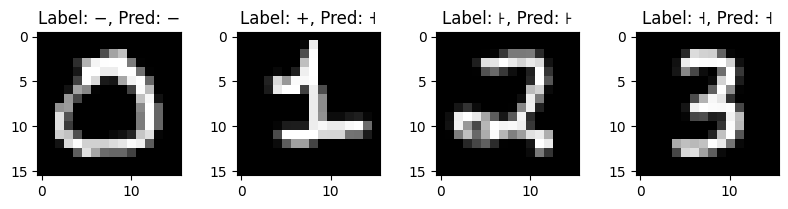

In [8]:
# show accuracy
x_vis_torch = torch.from_numpy(np.array(x_vis).reshape(4, -1))
y_vis_torch = torch.from_numpy(np.array(y_vis))
benign_preds = [qml_model(f) for f in x_vis_torch]

benign_class_output = [torch.argmax(p) for p in benign_preds]
visualize_data(x_vis, y_vis, benign_class_output)

### Adversarial attack - [PGD](https://adversarial-ml-tutorial.org/adversarial_examples/#projected-gradient-descent)

In [33]:
# simple implementation of projected gradient descent (PGD) attack (without randomized starting points — cf. BIM)
# for an introduction to PGD, see https://adversarial-ml-tutorial.org/adversarial_examples/#projected-gradient-descent
def PGD(model, feats, labels, epsilon=0.1, alpha=0.01, num_iter=10):

    # initialize image perturbations with zero
    delta = torch.zeros_like(feats, requires_grad=True)
    for t in range(num_iter):
        feats_adv = feats + delta
        outputs = [model(f) for f in feats_adv]

        # forward & backward pass through the model, accumulating gradients
        l = loss(torch.stack(outputs), labels)
        l.backward()

        # use gradients with respect to inputs and clip the results to lie within the epsilon boundary
        delta.data = (delta + alpha * delta.grad.detach().sign()).clamp(-epsilon, epsilon)
        delta.grad.zero_()
    return delta.detach()

### Evaluation - adversarial samples

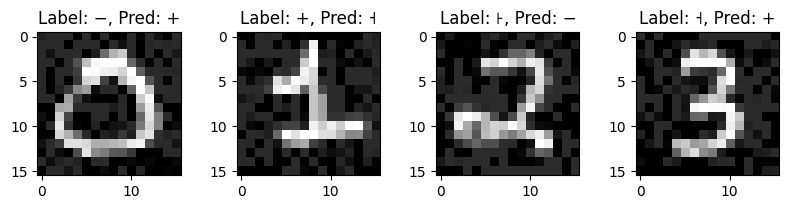

In [34]:
perturbations = PGD(model=qml_model, feats=x_vis_torch, labels=y_vis_torch, epsilon=0.1) # even smaller values of epsilon do some damage (epsilon > 0.04)
perturbed_x = x_vis_torch + perturbations

# check model performance
adversarial_preds = [qml_model(f) for f in perturbed_x]
adversarial_class_output = [torch.argmax(p) for p in adversarial_preds]

visualize_data(perturbed_x.reshape(-1, 16, 16), y_vis, adversarial_class_output)

In [40]:
adv_x = torch.from_numpy(np.array(x_test[0:100].reshape(100,-1)))
adv_y = torch.from_numpy(np.array(y_test[0:100]))

In [41]:
eps = np.linspace(0, 0.2, 10)

for ep in eps:
    perturbations = PGD(model=qml_model, feats=adv_x, labels=adv_y, epsilon=ep)
    perturbed_x = adv_x + perturbations
    # adv_pred = [qml_model(f) for f in perturbed_x]

TypeError: clamp() received an invalid combination of arguments - got (tensor, tensor), but expected one of:
 * (Tensor min = None, Tensor max = None)
      didn't match because some of the arguments have invalid types: (!tensor!, !tensor!)
 * (Number min = None, Number max = None)
      didn't match because some of the arguments have invalid types: (!tensor!, !tensor!)


In [42]:
perturbations = PGD(model=qml_model, feats=adv_x, labels=adv_y, epsilon=0.1)
perturbed_x = adv_x + perturbations

KeyboardInterrupt: 

### Adversarial robustness

by data augmentation (including some perturbed samples in training) - <strong>adversarial (re)training</strong> <br>
here, the model does not change, only trained on adversarial examples, which makes it robust against that particular type of attack

In [11]:
adv_dataset = (
    PGD(model=qml_model, feats=feats_train[:20], labels=labels_train[:20], epsilon=0.1)
    + feats_train[:20]
)

feats_retrain = torch.cat((feats_train, adv_dataset))
labels_retrain = torch.cat((labels_train, labels_train[:20]))
epochs_retraining = 2

for ep in range(0, epochs_retraining):
    batch_ind = gen_batches(num_train, num_batches)
    print_acc(epoch=ep, max_ep=2)

    for it in range(num_batches):
        optimizer.zero_grad()
        feats_train_batch = feats_retrain[batch_ind[it]]
        labels_train_batch = labels_retrain[batch_ind[it]]

        outputs = [qml_model(f) for f in feats_train_batch]
        batch_loss = loss(torch.stack(outputs), labels_train_batch)
        # if REG:
        #    loss = loss + lipschitz_regularizer(regularization_rate, model.qcircuit.weights)
        batch_loss.backward()
        optimizer.step()

print_acc(epochs_retraining, max_ep=2)

Epoch 0/2 | Approx Cost (train): 0.9681479 | Cost (val): 0.9922172 | Approx Acc train: 0.8800000 | Acc val: 0.8400000
Epoch 1/2 | Approx Cost (train): 0.9573029 | Cost (val): 1.0042179 | Approx Acc train: 0.8600000 | Acc val: 0.7800000
Epoch 2/2 | Approx Cost (train): 0.9427876 | Cost (val): 0.9823330 | Approx Acc train: 0.8400000 | Acc val: 0.8100000


### Evaluation - robust model

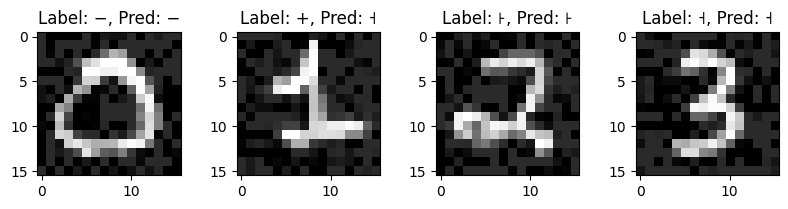

In [12]:
adversarial_preds = [qml_model(f) for f in perturbed_x]
adversarial_class_output = [torch.argmax(p) for p in adversarial_preds]

visualize_data(perturbed_x.reshape(-1, 16, 16), y_vis, adversarial_class_output)

## Next steps
* test the above model throughout the dataset to compare the accuracy in each case and for each label ('+' seems to be the mmost vulnerable at a first glance)
    * samples near the decisino boundary are more susceptible
* explore Lipschitz regularisation
* implement the [paper](https://ieeexplore.ieee.org/document/10821377/) 